# Importações

In [ ]:
#!pip install scikit-learn pandas numpy matplotlib

In [6]:
import shap

import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt

# Pré-processamento e pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Modelos de ML
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# Validação e busca de hiperparâmetros
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score

# Métricas
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

# Regressão Random Forest
from sklearn.ensemble import RandomForestRegressor

# Carregando dataset

In [5]:
# Carregar o dataset
df = pd.read_csv('filmes_gabriel.csv')

# Identificando e tratando outliers em variáveis numéricas do df

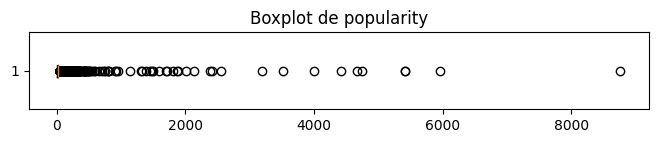

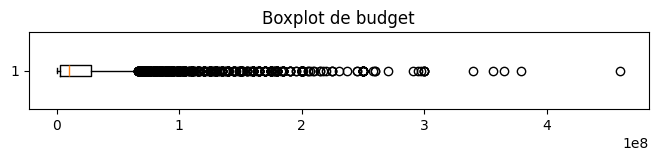

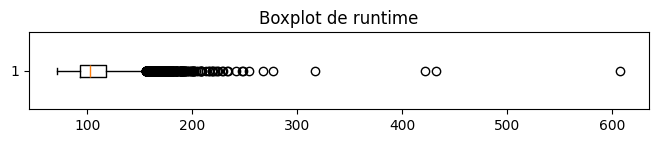

In [7]:
numeric_cols = df[['popularity', 'budget', 'runtime']].columns

for col in numeric_cols:
    plt.figure(figsize=(8, 1))
    plt.boxplot(df[col], vert=False)
    plt.title(f'Boxplot de {col}')
    plt.show()

### Tratamento com Cap nos outliers
 - Função para aplicar o "cap" nos outliers usando o método do IQR (Interquartile Range).
 - O cap limita os valores extremos (outliers) ao valor máximo permitido pelo intervalo interquartil,
 - reduzindo o impacto desses valores sem removê-los do dataset.

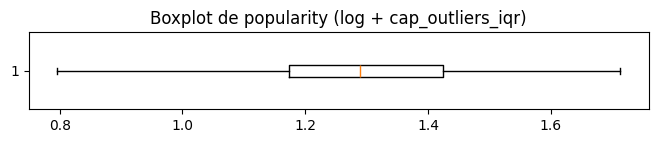

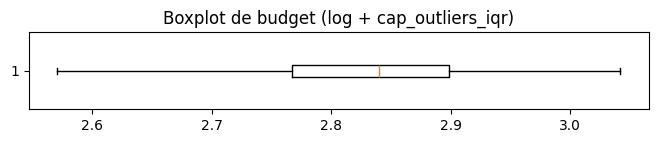

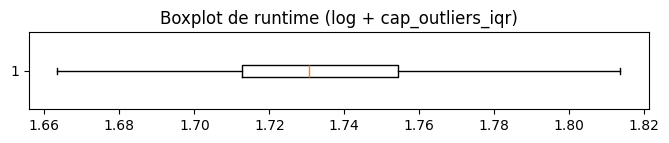

In [9]:
def log_transform(df, columns):
    for col in columns:
        # Adiciona 1 para evitar log(0)
        df[col] = np.log1p(df[col])
    return df

def cap_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df[col] = df[col].clip(lower, upper)
    return df

df = log_transform(df, numeric_cols)
df = cap_outliers_iqr(df, numeric_cols)

for col in numeric_cols:
    plt.figure(figsize=(8, 1))
    plt.boxplot(df[col], vert=False)
    plt.title(f'Boxplot de {col} (log + cap_outliers_iqr)')
    plt.show()
